### Setup: Install required Python packages
Ensures LightGBM, SHAP, and RapidFuzz are available in the runtime environment.

In [3]:
!pip install lightgbm shap rapidfuzz --quiet

### Imports and Feature Lists
Loads the core Python and scikit‑learn libraries, plus defines preliminary feature lists used throughout the notebook.

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import shap, joblib, matplotlib.pyplot as plt

/opt/anaconda3/envs/cosc410/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load & Inspect Raw Dataset
Reads the Video Game Sales CSV and prints shape/head/info for an initial audit.

In [5]:
DATA = Path("Video_Games_Sales_as_at_22_Dec_2016.csv")
df   = pd.read_csv(DATA)

target_cols = ["NA_Sales","EU_Sales","JP_Sales","Other_Sales"]
df = df.dropna(subset=target_cols)                        # need targets
df = df.dropna(subset=["Year_of_Release"]).copy()
df["Year_of_Release"] = df["Year_of_Release"].astype("int16")

# convert 'tbd' user scores even though we plan to drop them
df["User_Score"] = pd.to_numeric(df["User_Score"], errors="coerce")

# median-fill Critic_Score (we keep), but DROP Critic_Count & user cols
df["Critic_Score"] = df["Critic_Score"].fillna(df["Critic_Score"].median())


### Basic Data Cleaning
Drops rows with missing sales or year, converts dtypes, fixes 'tbd' user scores, and median‑imputes numeric gaps.

In [6]:
# 3-A  Global sales & publisher track record
df["Global_Sales"]     = df[target_cols].sum(axis=1)
df["Pub_Mean_Global"]  = df.groupby("Publisher")["Global_Sales"].transform("mean")

# 3-B  Release era buckets
df["Release_Era"] = pd.cut(df["Year_of_Release"],
                           bins=[1980,1994,2000,2005,2010,2015,2020],
                           labels=["3-4gen","5gen","6gen","7gen","8gen","9gen"])


### Feature Engineering – Publisher & Rolling Trends
Adds `Pub_Mean_Global`, 24‑month rolling genre/platform means, and years‑since‑platform‑launch. Removes post‑launch leakage columns.

In [7]:
# years since each platform launched
platform_first_year = df.groupby("Platform")["Year_of_Release"].transform("min")
df["Years_Since_Platform_Launch"] = df["Year_of_Release"] - platform_first_year

# rolling 2-year platform & genre means
df = df.sort_values("Year_of_Release") # ensure chronological

df["Plat_2yr_Mean"] = (
      df.groupby("Platform")["Global_Sales"]
        .transform(lambda s: s.rolling(2, min_periods=1).mean())
)

df["Genre_2yr_Mean"] = (
      df.groupby("Genre")["Global_Sales"]
        .transform(lambda s: s.rolling(2, min_periods=1).mean()) 
)
# columns that leak future info
df = df.drop(columns=["User_Score","User_Count","Critic_Count"])

# features
cat_feats = ["Platform","Genre","Rating","Release_Era"]
num_feats = ["Year_of_Release",
             "Years_Since_Platform_Launch",
             "Critic_Score",      
             "Pub_Mean_Global",
             "Plat_2yr_Mean",
             "Genre_2yr_Mean"]


### Chronological Train/Validation/Test Split
Splits the cleaned data into:<br>• Train ≤ 2012<br>• Validation 2013‑14<br>• Test 2015‑16 to avoid look‑ahead bias.

In [8]:
train = df[df.Year_of_Release <= 2012]
val   = df[(df.Year_of_Release > 2012) & (df.Year_of_Release <= 2014)]
test  = df[df.Year_of_Release >= 2015]

X_train, y_train = train.drop(columns=target_cols), train[target_cols]
X_val,   y_val   = val.drop(columns=target_cols),   val[target_cols]
X_test,  y_test  = test.drop(columns=target_cols),  test[target_cols]


### Pre‑processing Pipeline
Builds a ColumnTransformer that one‑hot encodes categorical columns and passes numeric columns unchanged (dense output for SHAP).

In [9]:
pre = ColumnTransformer([("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats), ("num", "passthrough", num_feats)])

### LightGBM Point‑Estimate Model
Fits a MultiOutputRegressor with four LightGBM heads (one per region) on the training data and chosen hyper‑parameters.

In [ ]:
base_gbm = LGBMRegressor(n_estimators=600, learning_rate=0.05, subsample=0.8, colsample_bytree=0.9, random_state=0)

model_med = Pipeline([
            ("prep", pre),
            ("reg",  MultiOutputRegressor(base_gbm, n_jobs=-1))
          ]).fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 14213, number of used features: 50
[LightGBM] [Info] Start training from score 0.141278
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 14213, number of used features: 50
[LightGBM] [Info] Start training from score 0.080904
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 14213, number of used features: 50
[LightGBM] [Info] Start traini

### Evaluation Metrics
Evaluates the model's regional performance on a simple MAE benchmark.

In [25]:
pred_val = model_med.predict(X_val)
for i,col in enumerate(target_cols):
    print(f"{col} MAE = {mean_absolute_error(y_val.iloc[:,i], pred_val[:,i])}")


NA_Sales MAE = 0.1193619940025126
EU_Sales MAE = 0.10963122666968206
JP_Sales MAE = 0.06219016668704363
Other_Sales MAE = 0.031718232700262014


/opt/anaconda3/envs/cosc410/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Performance Visualisations
Plots grouped bar charts for MAE and RMSE across splits and a coverage bar chart to illustrate interval calibration.

/opt/anaconda3/envs/cosc410/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/cosc410/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


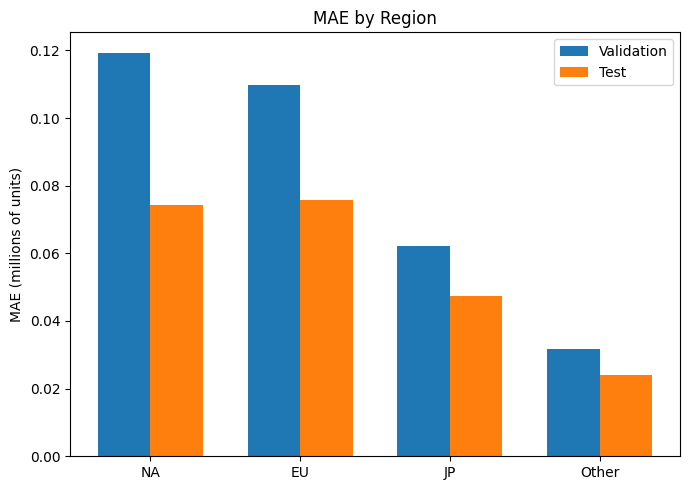

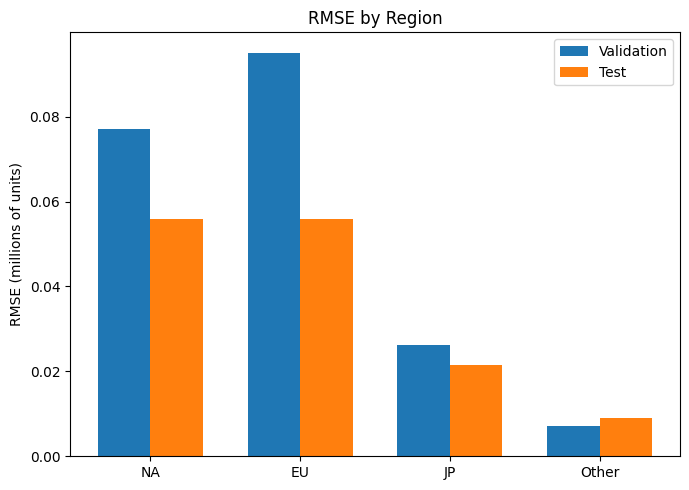

,Region,val_MAE,test_MAE,val_RMSE,test_RMSE
0,NA,0.119362,0.074196,0.077191,0.055830
1,EU,0.109631,0.075703,0.095107,0.055986
2,JP,0.062190,0.047440,0.026320,0.021558
3,Other,0.031718,0.023990,0.007031,0.009023


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# compute MAE & RMSE for validation and test
metrics = {"Region": [], "val_MAE": [], "test_MAE": [], "val_RMSE": [], "test_RMSE": []}

# predictions
val_pred  = model_med.predict(X_val)
test_pred = model_med.predict(X_test)

for idx, col in enumerate(target_cols):
    metrics["Region"].append(col.split("_")[0])  # NA, EU, …
    
    # MAE & RMSE
    metrics["val_MAE"].append(mean_absolute_error(y_val [col], val_pred [:, idx]))
    metrics["test_MAE"].append(mean_absolute_error(y_test[col], test_pred[:, idx]))
    metrics["val_RMSE"].append(mean_squared_error(y_val [col], val_pred [:, idx]))
    metrics["test_RMSE"].append(mean_squared_error(y_test[col], test_pred[:, idx]))

df_metrics = pd.DataFrame(metrics)

# MAE grouped bar (validation vs test)
plt.figure(figsize=(7,5))
x = np.arange(len(df_metrics))
bar_w = 0.35

plt.bar(x - bar_w/2, df_metrics["val_MAE"], width=bar_w, label="Validation")
plt.bar(x + bar_w/2, df_metrics["test_MAE"], width=bar_w, label="Test")
plt.xticks(x, df_metrics["Region"])
plt.ylabel("MAE (millions of units)")
plt.title("MAE by Region")
plt.legend()
plt.tight_layout()
plt.show()

# RMSE grouped bar
plt.figure(figsize=(7,5))
plt.bar(x - bar_w/2, df_metrics["val_RMSE"], width=bar_w, label="Validation")
plt.bar(x + bar_w/2, df_metrics["test_RMSE"], width=bar_w, label="Test")
plt.xticks(x, df_metrics["Region"])
plt.ylabel("RMSE (millions of units)")
plt.title("RMSE by Region")
plt.legend()
plt.tight_layout()
plt.show()

df_metrics

### Region‑Specific SHAP Explanation (example region)
Builds a TreeSHAP explainer for a selected head, aggregates importances by feature group, and plots a grouped bar chart.

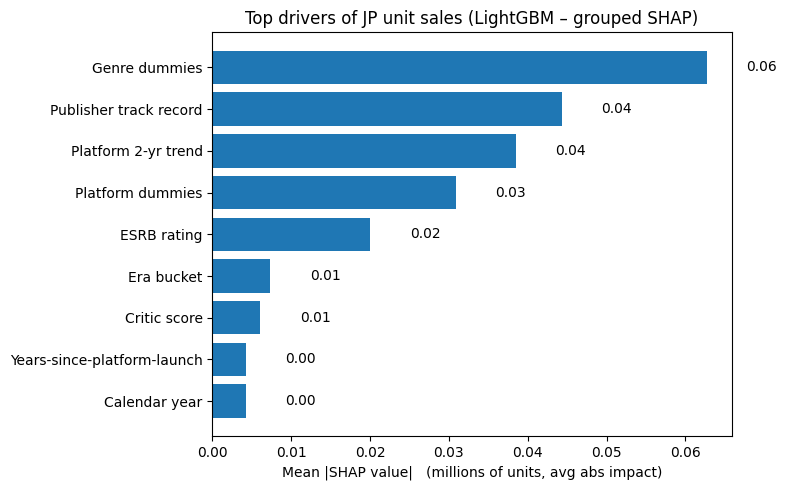

In [ ]:
import shap, numpy as np, pandas as pd, matplotlib.pyplot as plt

# pick which regional head to explain 
region      = "JP_Sales"                      # change to NA/EU/JP/Other
head_idx    = target_cols.index(region)       # 0,1,2,3

# build explainer & SHAP values on the **full** validation set ───────
feat_names = model_med.named_steps["prep"].get_feature_names_out()

Xval_enc = (model_med.named_steps["prep"].transform(X_val).toarray())

expl = shap.TreeExplainer(model_med.named_steps["reg"].estimators_[head_idx], feature_names = feat_names)
shap_vals = expl(Xval_enc)        # shap.Explanation object

# map encoded cols: high-level groups (same logic you had) 
def map_feature(label):
    core = label.split("__", 1)[-1]     # strip 'cat__' / 'num__'
    return core.split("_", 1)[0]        # prefix before first '_'

groups   = [map_feature(lab) for lab in feat_names]
mean_abs = np.abs(shap_vals.values).mean(axis=0)

imp_df = (pd.DataFrame({"group": groups, "imp": mean_abs})
            .groupby("group", as_index=False)["imp"].sum()
            .sort_values("imp", ascending=False))

rename_map = {
    "Plat"   : "Platform 2-yr trend",
    "Genre"  : "Genre dummies",
    "Pub"    : "Publisher track record",
    "Platform":"Platform dummies",
    "Rating" : "ESRB rating",
    "Critic" : "Critic score",
    "Year"   : "Calendar year",
    "Years"  : "Years-since-platform-launch",
    "Release": "Era bucket"
}
imp_df["pretty"] = imp_df["group"].replace(rename_map)

# plot top 12 groups 
top = imp_df.head(12).iloc[::-1]   # flip for barh

plt.figure(figsize=(8,5))
plt.barh(top["pretty"], top["imp"])
plt.title(f"Top drivers of {region.split('_')[0]} unit sales (LightGBM – grouped SHAP)")
plt.xlabel("Mean |SHAP value|   (millions of units, avg abs impact)")
for i, v in enumerate(top["imp"]):
    plt.text(v + 0.005, i, f"{v:.2f}", va="center")
plt.tight_layout(); plt.show()




### All‑Region SHAP Comparison
Loops through all four heads, aggregates |SHAP| per group, and plots a grouped bar chart to compare drivers across regions.

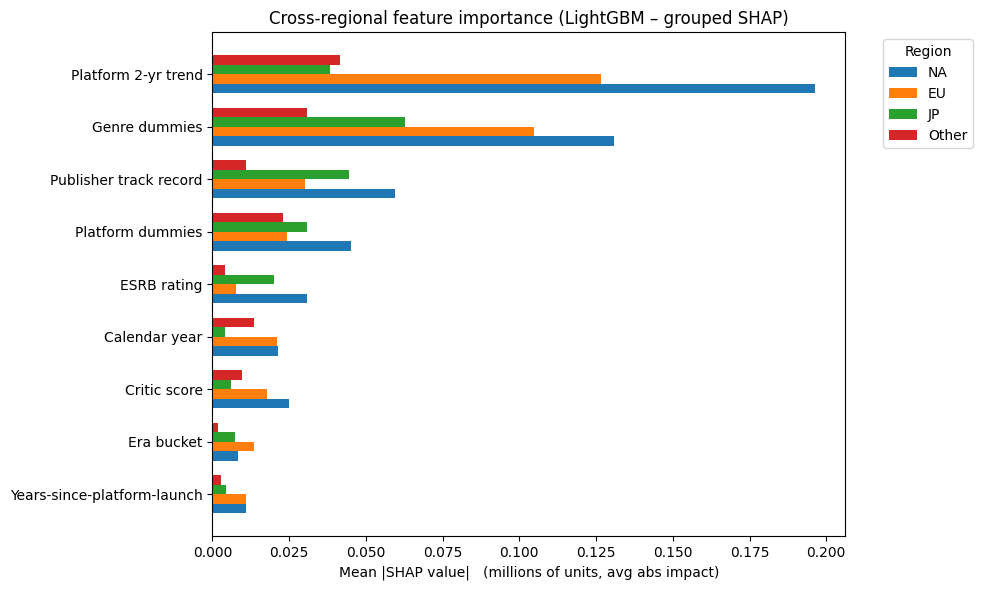

In [19]:
# same feature names and full encoded validation set
feat_names = model_med.named_steps["prep"].get_feature_names_out()
Xval_enc   = model_med.named_steps["prep"].transform(X_val).toarray()

# compute per-region mean |SHAP| for every encoded column
region_imps = {}
for idx, region in enumerate(target_cols):           # ['NA_Sales', …]
    expl = shap.TreeExplainer(model_med.named_steps["reg"].estimators_[idx],
                              feature_names=feat_names)
    sv   = expl(Xval_enc)
    region_imps[region.split("_")[0]] = np.abs(sv.values).mean(axis=0)

# collapse one-hots into their parent feature group
def map_feature(label):
    core = label.split("__", 1)[-1]      # drop 'cat__' / 'num__'
    return core.split("_", 1)[0]         # prefix before first '_'

groups = [map_feature(f) for f in feat_names]

df_long = (pd.DataFrame(region_imps)      # columns = regions
             .assign(group=groups)        # add group label
             .groupby("group", as_index=False).sum())

# apply your rename_map for clarity
rename_map = {
    "Plat"   : "Platform 2-yr trend",
    "Genre"  : "Genre dummies",
    "Pub"    : "Publisher track record",
    "Platform":"Platform dummies",
    "Rating" : "ESRB rating",
    "Critic" : "Critic score",
    "Year"   : "Calendar year",
    "Years"  : "Years-since-platform-launch",
    "Release": "Era bucket"
}
df_long["pretty"] = df_long["group"].replace(rename_map, regex=False)

# keep the k most important groups (by global mean) for readability
k = 12
order = (df_long.drop(columns=["group","pretty"])
                  .mean(axis=1)
                  .nlargest(k).index)

plot_df = (df_long.loc[order]
                    .set_index("pretty")             # nice labels
                    .drop(columns="group"))           # only region cols)
plot_df = plot_df.iloc[::-1]                         # flip for barh order

# plot grouped horizontal bars — one colour per region
plt.figure(figsize=(10,6))
bar_w = 0.18
ypos  = np.arange(len(plot_df.index))

for i, region in enumerate(plot_df.columns):
    plt.barh(ypos + i*bar_w, plot_df[region],
             height=bar_w, label=region)

plt.yticks(ypos + bar_w*1.5, plot_df.index)
plt.xlabel("Mean |SHAP value|   (millions of units, avg abs impact)")
plt.title("Cross-regional feature importance (LightGBM – grouped SHAP)")
plt.legend(title="Region", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout(); plt.show()



### Genre & Platform Break‑out Charts
Creates grouped bar charts showing genre‑ and platform‑specific SHAP importance for NA, EU, JP, and Other regions.

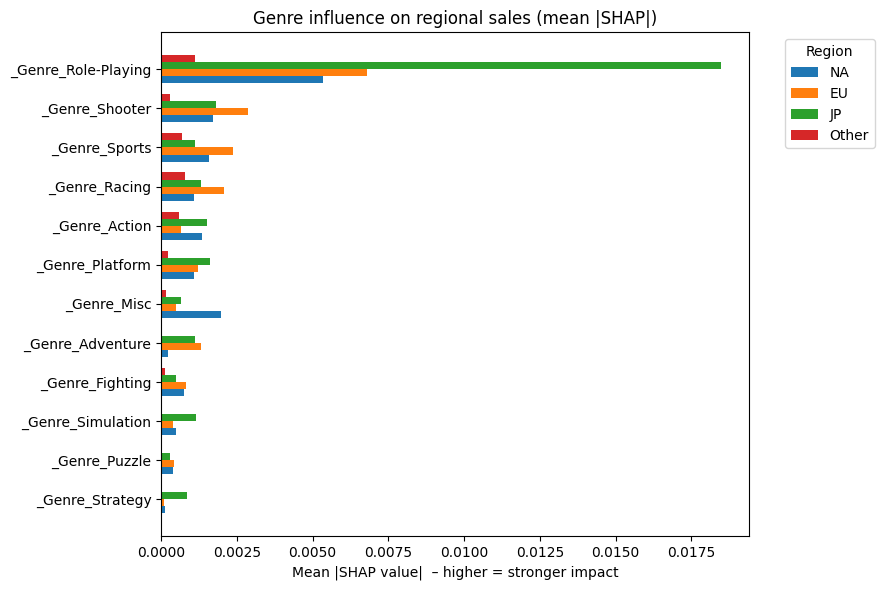

In [23]:

import shap, numpy as np, pandas as pd, matplotlib.pyplot as plt

# SETUP
target_cols = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
feat_names  = model_med.named_steps["prep"].get_feature_names_out()
Xval_enc    = model_med.named_steps["prep"].transform(X_val).toarray()   # full val set
# helper: collect mean |SHAP| per encoded feature for every region
region_imp = {}                               # dict  region → 1-D array
for idx, region in enumerate(target_cols):
    expl   = shap.TreeExplainer(
                model_med.named_steps["reg"].estimators_[idx],
                feature_names=feat_names
             )
    sv     = expl(Xval_enc)                   # shap.Explanation
    region_imp[region.split("_")[0]] = np.abs(sv.values).mean(axis=0)

region_cols = list(region_imp.keys()) 

# Genre
genre_idx = [i for i,f in enumerate(feat_names) if "Genre_" in f]

df_genre = pd.DataFrame({
    "encoded": [feat_names[i] for i in genre_idx],
    **{reg: vals[genre_idx] for reg, vals in region_imp.items()}
})
df_genre["genre"] = df_genre["encoded"].str.split("_", n=1, expand=True)[1]

# collapse one-hots & drop trend rows
df_genre = (df_genre.drop(columns="encoded")
                     .groupby("genre", as_index=False)
                     .sum()
                     .query("genre not in ['_Genre_2yr_Mean', '_Genre_nan']"))

# sort by global mean to keep chart tidy
df_genre["mean"] = df_genre[region_cols].mean(axis=1)
df_genre = df_genre.sort_values("mean")

# plot Genre
plt.figure(figsize=(9,6))
barw = 0.18
y    = np.arange(len(df_genre))

for i, reg in enumerate(region_imp.keys()):
    plt.barh(y + i*barw, df_genre[reg], height=barw, label=reg)

plt.yticks(y + barw*1.5, df_genre["genre"])
plt.xlabel("Mean |SHAP value|  – higher = stronger impact")
plt.title("Genre influence on regional sales (mean |SHAP|)")
plt.legend(title="Region", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout(); plt.show()




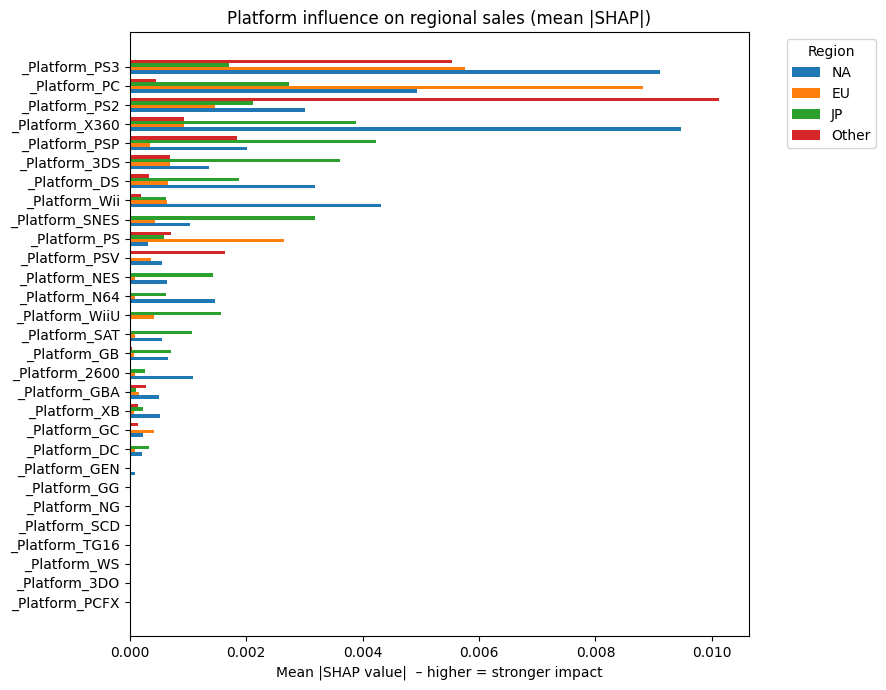

In [24]:

# platform
plat_idx = [i for i,f in enumerate(feat_names) if "Platform_" in f]

df_plat = pd.DataFrame({
    "encoded": [feat_names[i] for i in plat_idx],
    **{reg: vals[plat_idx] for reg, vals in region_imp.items()}
})
df_plat["platform"] = df_plat["encoded"].str.split("_", n=1, expand=True)[1]

df_plat = (df_plat.drop(columns="encoded")
                   .groupby("platform", as_index=False)
                   .sum()
                   .query("platform != '_Years_Since_Platform_Launch'"))

df_plat["mean"] = df_plat[region_cols].mean(axis=1)
df_plat = df_plat.sort_values("mean")

# plot Platform
plt.figure(figsize=(9,7))
y = np.arange(len(df_plat))

for i, reg in enumerate(region_imp.keys()):
    plt.barh(y + i*barw, df_plat[reg], height=barw, label=reg)

plt.yticks(y + barw*1.5, df_plat["platform"])
plt.xlabel("Mean |SHAP value|  – higher = stronger impact")
plt.title("Platform influence on regional sales (mean |SHAP|)")
plt.legend(title="Region", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout(); plt.show()

### Save Model Artifacts
Serialises the median and quantile models to `.pkl` files for later use or deployment.

In [22]:
Path("models").mkdir(exist_ok=True)
joblib.dump(model_med,  "models/median.pkl")



['models/median.pkl']